<a href="https://colab.research.google.com/github/jakkapongz/hotel-reviews-sentiment-analysis/blob/develop/colab/hotel_reviews_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

## Install Libraries




In [ ]:
# !pip -q install pytorch-lightning==1.3.8
!pip uninstall torch torchtext -y
!pip uninstall torchaudio torchvision -y
!pip uninstall fastai torchmetrics -y
# !pip -q install torch==1.5.0 torchtext==0.4.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html

# !pip -q install torch -f http://download.pytorch.org/whl/cu92/torch/torch-1.13.1-cp39-cp39-manylinux2014_aarch64.whl

# !pip-qinstalltorch-fhttp://download.pytorch.org/whl/cu92/torch/torch-1.4.0+cpu-cp38-cp38-linux_x86_64.whl


# !pip install torch==1.5.0

#!pip -q install transformers==3.5.1

#!pip -q install sentencepiece -f https://files.pythonhosted.org/packages/56/53/dd25e0a5f123ceb30eec1cc2cae947124bc43707620f35fdccdfd01b5350/sentencepiece-0.1.94-cp39-cp39-manylinux2014_s390x.whl

!pip -q install pythainlp
!pip install thai2transformers==0.1.1
# !pip -q install torch>=1.5.0 torchtext==0.4.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html

# !pip -q install torch==1.7.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/cu101/torch-1.7.1+cu101-cp39-cp39-linux_x86_64.whl
!pip -q install torch>=1.5.0+cu101 torchtext>=0.6.1+cu101 torchvision==0.8.2 -f https://download.pytorch.org/whl/cpu/torch_stable.html
# !pip -q install torch==1.7.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/cu101/torch-1.7.1+cu101-cp39-cp39-linux_x86_64.whl


!pip -q install wordcloud

!pip list

!pip freeze

Found existing installation: torch 1.13.1+cu116
Uninstalling torch-1.13.1+cu116:
  Successfully uninstalled torch-1.13.1+cu116
Found existing installation: torchtext 0.14.1
Uninstalling torchtext-0.14.1:
  Successfully uninstalled torchtext-0.14.1
Found existing installation: torchaudio 0.13.1+cu116
Uninstalling torchaudio-0.13.1+cu116:
  Successfully uninstalled torchaudio-0.13.1+cu116
Found existing installation: torchvision 0.14.1+cu116
Uninstalling torchvision-0.14.1+cu116:
  Successfully uninstalled torchvision-0.14.1+cu116
Found existing installation: fastai 2.7.11
Uninstalling fastai-2.7.11:
  Successfully uninstalled fastai-2.7.11
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 76.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3

## Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)
# SET PATH TO DATA FOLDER
path= "/content/drive/Shareddrives/EGIT697_THEMATIC"

Mounted at /content/drive/


In [ ]:
!python --version

Python 3.9.16


## Data Preparation

,property_id,review_id,hotel_name,rating,label,token_length,review_text,review_tokens
0,302577,2480789,Saichol GrandView,9.7,1,410,ผมเลือกพักที่แพสายชล รีสอร์ท เพราะได้รับการแนะ...,ผม เลือก พัก ที่ แพ สาย ชล รีสอร์ท เพราะ ได้รั...
1,237194,447658048,Chivapuri Beach Resort (SHA Extra Plus),8.0,1,394,รีวิวห้องสุพีเรียร์ บรรยากาศ: วิวทะเลสวยงาม ม...,รีวิว ห้อง สุ พี เรียร์ บรรยากาศ วิว ทะเล สวยง...
2,109169,362459238,Chatrium Hotel Riverside Bangkok (SHA Extra Plus),10.0,1,386,ที่จอดรถชั้นใต้ดินมีไฟสีออกส้มเลยดูค่อนข้างมืด...,ที่จอดรถ ชั้นใต้ดิน มี ไฟ สี ออก ส้ม เลย ดู ค่...
3,19855171,510816839,Sirin Hotel & Resident (SHA Extra Plus),8.0,1,386,ที่พักในขอนแก่นคืนนี้ จองผ่านอโกด้า ได้ในราคา ...,ที่พัก ใน ขอนแก่น คืนนี้ จอง ผ่า นอ โก ด้า ได้...
4,400378,279748565,Baan Na Khon Hotel,10.0,1,383,แฟนต้องเดินทางมาดูงานที่นครศรีธรรมราช 3 วัน เล...,แฟน ต้อง เดินทาง มา ดูงาน ที่ นครศรีธรรมราช 3 ...
...,...,...,...,...,...,...,...,...
7495,409353,8319287,Gecko Lipe Resort,9.0,1,61,ที่พักเป็นลักษณะคล้ายกระท่อม ไม่มีแอร์ มีมุ้งใ...,ที่พัก เป็น ลักษณะ คล้าย กระท่อม ไม่ มี แอร์ ม...
7496,108844,9895967,Tri Trang Beach Resort,10.0,1,61,ชอบที่นี้กลับมา2ครั้งแต่ครั้งนี้ชอบวิวความสะอา...,ชอบ ที่ นี้ กลับมา 2 ครั้ง แต่ ครั้งนี้ ชอบ วิ...
7497,446396,10359789,Ayothaya Riverside House,8.7,1,61,ที่พักน่ารัก ติดริมแม่น้ำ เหมือนเข้าพักบ้านญาต...,ที่พัก น่ารัก ติด ริมแม่น้ำ เหมือน เข้า พัก บ้...
7498,734875,10981013,Chandra Varin Hometel,10.0,1,61,ไปเชียงคานมาหลายรอบ พัก Home stay มาหลายที่แล้...,ไป เชียงคาน มา หลาย รอบ พัก homestay มา หลาย ท...


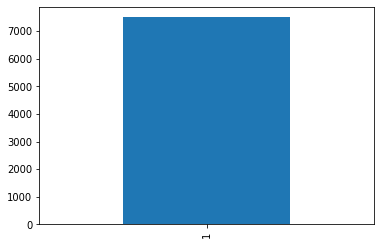

In [ ]:
import pandas as pd
import numpy as np

all_tsv_df = pd.read_csv(path + '/7500_good_longest_token_more_than_8_03082023.tsv', delimiter='\t')

all_tsv_df['label'].value_counts().plot.bar()

all_tsv_df

# all_df = pd.read_pickle(path + '/10000_good_bad_reviews_no_gap_02012023.pkl')

# all_df['label'].value_counts().plot.bar()

# all_df

# **Feature Extraction Method**


In [ ]:
import tensorflow as tf
import torch
import gc
import copy

# check GPU available?
torch.cuda.is_available()

False

## **Wangchanberta** (Monolingual Model)

In [ ]:
from transformers import (AutoTokenizer, AutoModel, pipeline, AutoModelForSequenceClassification)

# active GPU
# device = torch.device("cuda")
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = torch.device("cpu")

# model loading
wangchan_tokenizer = AutoTokenizer.from_pretrained(f'airesearch/wangchanberta-base-att-spm-uncased', output_hidden_states=True)
wangchan_model = AutoModel.from_pretrained(f'airesearch/wangchanberta-base-att-spm-uncased', output_hidden_states=True)
wangchan_model = wangchan_model.to(device)

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def adjust_encoded_input_wangchan(encoded_input):

  # delete first and last separator token and splits to 414 tokens
  input_ids_chunks = list(encoded_input['input_ids'][0][1:-1].split(414))
  attention_mask_chunks = list(encoded_input['attention_mask'][0][1:-1].split(414))

  for i in range(len(input_ids_chunks)):

    # add 5 to the first and 6 to last element tonsor padding len to 512 for transformer model 
    input_ids_chunks[i] = torch.cat([input_ids_chunks[i], torch.Tensor([6, 5]).long() ])
    # shifting 6 5
    input_ids_chunks[i] = torch.roll(input_ids_chunks[i], 1, 0)
    
    # padding len to 416 for transformer model
    pad_len = 416 - input_ids_chunks[i].shape[0]

    # 1 token represents padding <pad>
    input_ids_chunks[i] = torch.cat([input_ids_chunks[i], torch.Tensor([1] * pad_len).long()])

    if len(attention_mask_chunks[i]) == 414:
      attention_mask_chunks[i] = torch.cat([attention_mask_chunks[i], torch.Tensor([1] * 2).long()])
    else:
      attention_mask_chunks[i] = torch.cat([attention_mask_chunks[i], torch.Tensor([1] * 2).long()])
      attention_mask_chunks[i] = torch.cat([attention_mask_chunks[i], torch.Tensor([0] * (pad_len)).long()])

  input_ids = torch.stack(input_ids_chunks)
  attention_mask = torch.stack(attention_mask_chunks)

  input_dict = {
      'input_ids': input_ids.long(),
      'attention_mask': attention_mask.int()
  }

  return input_dict

adjust_encoded_input_wangchan method ที่ช่วยจัดการ split word tokens ที่ยาวเกินให้มีขนาด 416 ส่วนที่เหลือจะถูกทำการ padding ด้วย 1 ในฝั่งของ wangchanberta

In [ ]:
# EXAMPLE
text = "จากก้าวแรกที่ผ่านประตูทางเข้า ด้วยกลิ่นหอมของเครื่องหอมที่จัดไว้ของทางโรงแรมทำให้เกิดความรู้สึกของการต้อนรับที่อบอุ่นของเจ้าของโรงแรม ที่ไม่ได้เกิดจากบุคคล ผสมผสานกับการเอาใจใส่ของพนักงานที่ได้รับการฝึกอบรมมาอย่างดีทำให้รับรู้ได้ถึงคำว่าบริการ 5 ดาวในโรงแรมขนาดเล็ก ห้องพักที่เข้าพักเป็นห้องชั้นล่าง สำหรับตึก 2 ชั้นใกล้สระว่ายน้ำขนาดเล็ก ทำให้สะดวกในการเล่นน้ำในสระ ประกอบกับการออกแบบในสไตล์ Indochina ที่พบเห็นไม่บ่อยครั้งนัก ทำให้การพักผ่อนในครั้งนี้ นับเป็นการพักผ่อนที่สมบูรณ์แบบอีกครั้งหนึ่ง"

encoded_input = wangchan_tokenizer(text, return_tensors='pt').to(device)
encoded_input = adjust_encoded_input_wangchan(encoded_input)
encoded_input['input_ids'], encoded_input['input_ids'].size()

(tensor([[    5,    10,    32, 24588,  9180,   816,  5671,    10,    45,  8270,
          10998,  1741,    12,   375,   130,    16,    75,  1595,  1519,   827,
             16, 12297,    12,  4420,    16,   554,  1595,    10,  4338,  2483,
            918,    10,  8325,  1052,  7830, 11809,  1375, 13015,    26,  1679,
            116,  3524,  4568,  1169,   803,    10,    65,    10,   925,    20,
           1595,  3068,    10,  4987,    12, 18433,    17,   580,  9590,  1584,
           2358,    10,    47,  3083,   991,    40, 20648,  3068,  1675, 10291,
          10964,    20,  4972,    10,  3938,  3741,    20,  2070,    10,     3,
            496,  2397, 20611,    10,    12,  6236,    51,  4926,   215,    10,
           8994,  3125,  2347,    10,  3345,    24,  3125,    12,  5750,   457,
            183,     6,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,   

In [ ]:
def extract_last_four_with_wangchan(input_text, feature_extractor):

  encoded_input = wangchan_tokenizer(input_text, return_tensors='pt').to(device)
  encoded_input = adjust_encoded_input_wangchan(encoded_input)
  _, _, hidden_states = feature_extractor(**encoded_input)

  # use only last 4 layers 
  last_four_layers = [hidden_states[i] for i in (-1, -2, -3, -4)]

  # concat last 4 layers vectors then calculate mean between vectors
  cat_hidden_states = torch.cat(tuple(last_four_layers), dim=-1)
  cat_sentence_embedding = torch.mean(cat_hidden_states, dim=1).squeeze()

  # if document only has 1 batch, no need to sum vector
  if cat_sentence_embedding.shape[0] != 3072:

    doc_embedding = torch.sum(cat_sentence_embedding, dim=0)
  else:
    doc_embedding = copy.copy(cat_sentence_embedding)
  
  return doc_embedding.cpu().detach().numpy().astype('float64')

We can use the outputs of WangchanBERTa (or any transformer-based models) as document vectors as an example by [BramVanroy](https://github.com/BramVanroy/bert-for-inference/blob/master/introduction-to-bert.ipynb).

![](https://github.com/BramVanroy/bert-for-inference/raw/ab7c57d6e7c79faf83ac0f9b6595c4b3d660c43c/img/bert-feature-extraction-contextualized-embeddings.png)

In [ ]:
text = "จากก้าวแรกที่ผ่านประตูทางเข้า ด้วยกลิ่นหอมของเครื่องหอมที่จัดไว้ของทางโรงแรมทำให้เกิดความรู้สึกของการต้อนรับที่อบอุ่นของเจ้าของโรงแรม ที่ไม่ได้เกิดจากบุคคล ผสมผสานกับการเอาใจใส่ของพนักงานที่ได้รับการฝึกอบรมมาอย่างดีทำให้รับรู้ได้ถึงคำว่าบริการ 5 ดาวในโรงแรมขนาดเล็ก ห้องพักที่เข้าพักเป็นห้องชั้นล่าง สำหรับตึก 2 ชั้นใกล้สระว่ายน้ำขนาดเล็ก ทำให้สะดวกในการเล่นน้ำในสระ ประกอบกับการออกแบบในสไตล์ Indochina ที่พบเห็นไม่บ่อยครั้งนัก ทำให้การพักผ่อนในครั้งนี้ นับเป็นการพักผ่อนที่สมบูรณ์แบบอีกครั้งหนึ่ง"

print(wangchan_model)

# t_2 = extract_last_four_with_wangchan(text, wangchan_model)
# t_2

CamembertModel(
  (embeddings): CamembertEmbeddings(
    (word_embeddings): Embedding(25005, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): CamembertEncoder(
    (layer): ModuleList(
      (0): CamembertLayer(
        (attention): CamembertAttention(
          (self): CamembertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): CamembertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (

In [ ]:
len(t_2)

3072

## **Bert Model for Multilingual**

In [ ]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

device = torch.device("cpu")
# active GPU
# device = torch.device("cuda")
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', output_hidden_states=True)
bert_model = BertModel.from_pretrained("bert-base-multilingual-cased", output_hidden_states=True)
bert_model = bert_model.to(device)
# bert_class = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
a = torch.Tensor([102, 101]).long()
c = torch.Tensor([1] * 2).long()
def adjust_encoded_input(encoded_input):

  # delete first and last separator token and splits to 510 tokens
  input_ids_chunks = list(encoded_input['input_ids'][0][1:-1].split(510))
  attention_mask_chunks = list(encoded_input['attention_mask'][0][1:-1].split(510))

  for i in range(len(input_ids_chunks)):

    # add 101 to the first and 102 to last element tonsor padding len to 512 for transformer model 
    input_ids_chunks[i] = torch.cat([input_ids_chunks[i], a ])
    # shifting 101 102
    input_ids_chunks[i] = torch.roll(input_ids_chunks[i], 1, 0)
    
    # padding len to 512 for transformer model
    pad_len = 512 - input_ids_chunks[i].shape[0]
    b = torch.Tensor([0] * pad_len).long()

    input_ids_chunks[i] = torch.cat([input_ids_chunks[i], b])

    if len(attention_mask_chunks[i]) == 510:
      attention_mask_chunks[i] = torch.cat([attention_mask_chunks[i], c])
    else:
      d = torch.Tensor([0] * (pad_len)).long()
      attention_mask_chunks[i] = torch.cat([attention_mask_chunks[i], c])
      attention_mask_chunks[i] = torch.cat([attention_mask_chunks[i], d])

  input_ids = torch.stack(input_ids_chunks)
  attention_mask = torch.stack(attention_mask_chunks)

  input_dict = {
      'input_ids': input_ids.long(),
      'attention_mask': attention_mask.int()
  }

  return input_dict

method ที่ช่วยจัดการ split word tokens ที่ยาวเกินให้มีขนาด 512 ส่วนที่เหลือจะถูกทำการ padding ด้วย 0 ในฝั่งของ bert

In [ ]:
text = "จากก้าวแรกที่ผ่านประตูทางเข้า ด้วยกลิ่นหอมของเครื่องหอมที่จัดไว้ของทางโรงแรมทำให้เกิดความรู้สึกของการต้อนรับที่อบอุ่นของเจ้าของโรงแรม ที่ไม่ได้เกิดจากบุคคล ผสมผสานกับการเอาใจใส่ของพนักงานที่ได้รับการฝึกอบรมมาอย่างดีทำให้รับรู้ได้ถึงคำว่าบริการ 5 ดาวในโรงแรมขนาดเล็ก ห้องพักที่เข้าพักเป็นห้องชั้นล่าง สำหรับตึก 2 ชั้นใกล้สระว่ายน้ำขนาดเล็ก ทำให้สะดวกในการเล่นน้ำในสระ ประกอบกับการออกแบบในสไตล์ Indochina ที่พบเห็นไม่บ่อยครั้งนัก ทำให้การพักผ่อนในครั้งนี้ นับเป็นการพักผ่อนที่สมบูรณ์แบบอีกครั้งหนึ่ง"

encoded_input = bert_tokenizer(text, return_tensors='pt').to(device)
encoded_input = adjust_encoded_input(encoded_input)
encoded_input['input_ids'], encoded_input['input_ids'].size()

(tensor([[   101,  85706,  18427,  43102,  31287, 111432,  22765,  18427,  18203,
          111420,  38999,  16000,  49292,  22765,  22598,  30011,  38468,  37022,
           65979, 111431,  80814,  43102,    100,  53470, 111435,  17405,  31904,
          111435,  81831, 111431, 100631,  46856, 101983,  49097,  53936,  31256,
           31256,  20507,   1420,  28767,  17405, 111420,  28767,  44121,  47260,
           53123, 111431,  33178,  17344, 111434,  46856, 111434,  28767,  31904,
           80814,  31142,  39901,  16000,  69365,  19197,  44121,  18203, 111435,
           81831,  22765, 102269,  53123, 111421, 111428,  18427, 108723,  65266,
           66845, 100145,  38999,  19197,  57209,  37022,  55593, 111434, 111424,
           35933,  22765, 102269,  22765,  38468,  35933, 111435,  81831, 111419,
          111428,  19197,  31256, 110429,  49097,  22765, 109453,  52780,    126,
            1412,  65530,  75890, 111433,  22765,  19197, 111432,  65266,  80814,
           62904

In [ ]:
def extract_last_four_with_bert(input_text, feature_extractor):
  encoded_input = bert_tokenizer(input_text, return_tensors='pt').to(device)
  encoded_input = adjust_encoded_input_wangchan(encoded_input)
  # hidden_states = feature_extractor(**encoded_input)[0]
  _, _, hidden_states = feature_extractor(**encoded_input)

  # FOR MEAN CALCULATION BETWEEN TENSOR DIMENSION

  last_four_layers = [hidden_states[i] for i in (-1, -2, -3, -4)]

  cat_hidden_states = torch.cat(tuple(last_four_layers), dim=-1)
  cat_sentence_embedding = torch.mean(cat_hidden_states, dim=1).squeeze()

  if cat_sentence_embedding.shape[0] != 3072:

    doc_embedding = torch.sum(cat_sentence_embedding, dim=0)
  else:
    doc_embedding = copy.copy(cat_sentence_embedding)

  return doc_embedding.cpu().detach().numpy().astype('float64')

In [ ]:
text = "จากก้าวแรกที่ผ่านประตูทางเข้า ด้วยกลิ่นหอมของเครื่องหอมที่จัดไว้ของทางโรงแรมทำให้เกิดความรู้สึกของการต้อนรับที่อบอุ่นของเจ้าของโรงแรม ที่ไม่ได้เกิดจากบุคคล ผสมผสานกับการเอาใจใส่ของพนักงานที่ได้รับการฝึกอบรมมาอย่างดีทำให้รับรู้ได้ถึงคำว่าบริการ 5 ดาวในโรงแรมขนาดเล็ก ห้องพักที่เข้าพักเป็นห้องชั้นล่าง สำหรับตึก 2 ชั้นใกล้สระว่ายน้ำขนาดเล็ก ทำให้สะดวกในการเล่นน้ำในสระ ประกอบกับการออกแบบในสไตล์ Indochina ที่พบเห็นไม่บ่อยครั้งนัก ทำให้การพักผ่อนในครั้งนี้ นับเป็นการพักผ่อนที่สมบูรณ์แบบอีกครั้งหนึ่ง"

t_2 = extract_last_four_with_bert(text, bert_model)
t_2

TypeError: ignored

In [ ]:
len(t_2)

3072

## **XLM-RoberTa Model for Multilingual**

In [ ]:
from transformers import AutoTokenizer, XLMRobertaModel

device = torch.device("cpu")

xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", output_hidden_states=True)
xlmr_model = XLMRobertaModel.from_pretrained("xlm-roberta-base", output_hidden_states=True)
xlmr_model = xlmr_model.to(device)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
a = torch.Tensor([102, 101]).long()
c = torch.Tensor([1] * 2).long()
def adjust_encoded_input_xlmr(encoded_input):

  # delete first and last separator token and splits to 510 tokens
  input_ids_chunks = list(encoded_input['input_ids'][0][1:-1].split(510))
  attention_mask_chunks = list(encoded_input['attention_mask'][0][1:-1].split(510))

  for i in range(len(input_ids_chunks)):

    # add 101 to the first and 102 to last element tonsor padding len to 512 for transformer model 
    input_ids_chunks[i] = torch.cat([input_ids_chunks[i], a ])
    # shifting 101 102
    input_ids_chunks[i] = torch.roll(input_ids_chunks[i], 1, 0)
    
    # padding len to 512 for transformer model
    pad_len = 512 - input_ids_chunks[i].shape[0]
    b = torch.Tensor([0] * pad_len).long()

    input_ids_chunks[i] = torch.cat([input_ids_chunks[i], b])

    if len(attention_mask_chunks[i]) == 510:
      attention_mask_chunks[i] = torch.cat([attention_mask_chunks[i], c])
    else:
      d = torch.Tensor([0] * (pad_len)).long()
      attention_mask_chunks[i] = torch.cat([attention_mask_chunks[i], c])
      attention_mask_chunks[i] = torch.cat([attention_mask_chunks[i], d])

  input_ids = torch.stack(input_ids_chunks)
  attention_mask = torch.stack(attention_mask_chunks)

  input_dict = {
      'input_ids': input_ids.long(),
      'attention_mask': attention_mask.int()
  }

  return input_dict

In [ ]:
# EXAMPLE
text = "จากก้าวแรกที่ผ่านประตูทางเข้า ด้วยกลิ่นหอมของเครื่องหอมที่จัดไว้ของทางโรงแรมทำให้เกิดความรู้สึกของการต้อนรับที่อบอุ่นของเจ้าของโรงแรม ที่ไม่ได้เกิดจากบุคคล ผสมผสานกับการเอาใจใส่ของพนักงานที่ได้รับการฝึกอบรมมาอย่างดีทำให้รับรู้ได้ถึงคำว่าบริการ 5 ดาวในโรงแรมขนาดเล็ก ห้องพักที่เข้าพักเป็นห้องชั้นล่าง สำหรับตึก 2 ชั้นใกล้สระว่ายน้ำขนาดเล็ก ทำให้สะดวกในการเล่นน้ำในสระ ประกอบกับการออกแบบในสไตล์ Indochina ที่พบเห็นไม่บ่อยครั้งนัก ทำให้การพักผ่อนในครั้งนี้ นับเป็นการพักผ่อนที่สมบูรณ์แบบอีกครั้งหนึ่ง"

encoded_input = xlmr_tokenizer(text, return_tensors='pt').to(device)
encoded_input = adjust_encoded_input_xlmr(encoded_input)
encoded_input['input_ids'], encoded_input['input_ids'].size()

(tensor([[   101,  11371, 100552,  21573,    699,  13801,  38196,   4436,   9373,
           25781,  88819,  68644,   1037,  16581,  68644,    699,  16491,  11407,
            1037,   4436,  29890, 164544, 119074,  63570, 118040,    699, 222353,
            1037,  72131,  29890,   5261,  12707, 134836,  40215,      6, 240232,
           71927,  17218,   6299,  17057,   1037,  38475, 212124,  69214,  88516,
            2131,   5943,   3641,  18729,   8448,  21268,   1547,   8959, 139295,
           31698,    190, 116082,   1201,  29890,  84656,      6,  66316,    699,
          145542,   1805,  27163,  26089, 145360,  19517, 171344,    116,  53067,
           44839, 167119,  84656,  32404,  62676,   1201, 114538,   5763,   1201,
          162714,      6,  36385,   2623, 152422,   1201,  69194,  93951,  42072,
            5261,  24006,  19575,   3379, 119615,  40480,  17448,  32404,   1834,
          127040,   1201, 108444,      6,  50460,  59193, 127040,    699,  89356,
            5938

In [ ]:
def extract_last_four_with_xlmr(input_text, feature_extractor):
  encoded_input = xlmr_tokenizer(input_text, return_tensors='pt').to(device)
  encoded_input = adjust_encoded_input_wangchan(encoded_input)
  # hidden_states = feature_extractor(**encoded_input)[0]
  _, _, hidden_states = feature_extractor(**encoded_input)

  # FOR MEAN CALCULATION BETWEEN TENSOR DIMENSION

  last_four_layers = [hidden_states[i] for i in (-1, -2, -3, -4)]

  cat_hidden_states = torch.cat(tuple(last_four_layers), dim=-1)
  cat_sentence_embedding = torch.mean(cat_hidden_states, dim=1).squeeze()

  if cat_sentence_embedding.shape[0] != 3072:

    doc_embedding = torch.sum(cat_sentence_embedding, dim=0)
  else:
    doc_embedding = copy.copy(cat_sentence_embedding)

  return doc_embedding.cpu().detach().numpy().astype('float64')

In [ ]:
text = "จากก้าวแรกที่ผ่านประตูทางเข้า ด้วยกลิ่นหอมของเครื่องหอมที่จัดไว้ของทางโรงแรมทำให้เกิดความรู้สึกของการต้อนรับที่อบอุ่นของเจ้าของโรงแรม ที่ไม่ได้เกิดจากบุคคล ผสมผสานกับการเอาใจใส่ของพนักงานที่ได้รับการฝึกอบรมมาอย่างดีทำให้รับรู้ได้ถึงคำว่าบริการ 5 ดาวในโรงแรมขนาดเล็ก ห้องพักที่เข้าพักเป็นห้องชั้นล่าง สำหรับตึก 2 ชั้นใกล้สระว่ายน้ำขนาดเล็ก ทำให้สะดวกในการเล่นน้ำในสระ ประกอบกับการออกแบบในสไตล์ Indochina ที่พบเห็นไม่บ่อยครั้งนัก ทำให้การพักผ่อนในครั้งนี้ นับเป็นการพักผ่อนที่สมบูรณ์แบบอีกครั้งหนึ่ง"

t_2 = extract_last_four_with_xlmr(text, xlmr_model)
t_2

array([0.11252412, 0.06388081, 0.01829687, ..., 0.16430743, 0.06374876,
       0.0098913 ])

In [ ]:
len(t_2)

3072

## Extract last four from data

In [ ]:
wangchan_vectors = []
bert_vectors = []
xlmr_vectors = []

for idx, row in all_tsv_df.iterrows():
  text = row['review_text']
  wangchan_vector = extract_last_four_with_wangchan(text, wangchan_model)
  bert_vector = extract_last_four_with_bert(text, bert_model)
  xlmr_vector = extract_last_four_with_xlmr(text, xlmr_model)
  wangchan_vectors.append(wangchan_vector)
  bert_vectors.append(bert_vector)
  xlmr_vectors.append(xlmr_vector)
  print(idx)

all_tsv_df['content_bert_vector'] = bert_vectors
all_tsv_df['content_wangchan_vector'] = wangchan_vectors
all_tsv_df['content_xlmr_vector'] = xlmr_vectors

all_tsv_df.to_pickle(path + "/7500_good_longest_token_more_than_8_03082023.tsv.pkl")

NameError: ignored

,property_id,review_id,hotel_name,rating,label,review_text,review_token,content_bert_vector,content_wangchan_vector,content_xlmr_vector
5000,296377,212354962,12 PM Bangkok,7.6,GOOD,ที่พักราคาไม่แพง และอยู่ไม่ไกลจาก BTS เพลินจิต...,ที่พัก ราคา ไม่ แพง และ อยู่ ไม่ ไกล จาก B...,"[-0.08499729633331299, -0.35263606905937195, 0...","[1.4595955610275269, 0.6573415994644165, 0.230...","[0.07647304981946945, 0.10066719353199005, 0.0..."
5001,296377,120713863,12 PM Bangkok,7.6,GOOD,ไปใช้บริการสองครั้ง ถือว่าคุ้มกับราคานี้ถ้าเที...,ไป ใช้ บริการ สอง ครั้ง ถือว่า คุ้ม กับ ราคา...,"[-0.018311381340026855, -0.4625507891178131, 0...","[0.2177482545375824, 0.04375092312693596, -0.0...","[0.07545724511146545, 0.07585924863815308, 0.0..."
5002,296377,105500792,12 PM Bangkok,8.0,GOOD,ที่พักค่อนข้างเป็นส่วนตัว เงียบ ไม่วุ่นวาย สาม...,ที่พัก ค่อนข้าง เป็น ส่วนตัว เงียบ ไม่ วุ่...,"[0.025015320628881454, -0.39137738943099976, 0...","[0.7288393378257751, 0.23021897673606873, -0.2...","[0.07480709999799728, 0.07126562297344208, 0.0..."
5003,296377,145300406,12 PM Bangkok,8.4,GOOD,การเดินทางสะดวกเพราะสามารถนั่งBTSไปลงสถานีเพลิ...,การ เดินทาง สะดวก เพราะ สามารถ นั่ง BTS ไป ลง ...,"[-0.1692434698343277, -0.3681756556034088, 0.2...","[0.0355386957526207, -0.6417447328567505, 0.55...","[0.0824437290430069, 0.05136942118406296, 0.03..."
5004,90659,6841875,13 Coins Airport Grand Resort,7.0,GOOD,พออยู่ได้ เพราะแค่ใช้เป็นที่นอนกับเก็บกระเป๋าเ...,พอ อยู่ ได้ เพราะ แค่ ใช้ เป็น ที่นอน กับ เก...,"[-0.05392926186323166, -0.7674156427383423, 0....","[1.342065691947937, 0.49130645394325256, 0.351...","[0.06383886188268661, 0.08241716027259827, 0.0..."
...,...,...,...,...,...,...,...,...,...,...
9995,445001,12380268,Wave Hotel (SHA Plus+),9.0,GOOD,อาหารเช้า A La Cart ที่ยอดเยี่ยมเป็นสิ่งที่ดึง...,อาหารเช้า A La Cart ที่ ยอดเยี่ยม เป็น...,"[0.026066772639751434, -0.8020034432411194, 0....","[0.9985324144363403, -0.5466135740280151, 0.29...","[0.06431634724140167, 0.06075471267104149, 0.0..."
9996,445001,7819549,Wave Hotel (SHA Plus+),10.0,GOOD,ตอนแรกที่เห็นโรงแรมนี้จากข้างนอกรู้สึกเฉยๆ พอไ...,ตอนแรก ที่ เห็น โรงแรม นี้ จาก ข้างนอก รู้สึก ...,"[-0.07836630940437317, -0.3555515706539154, 0....","[0.7709451913833618, 0.6884485483169556, -0.55...","[0.09320715069770813, 0.0814492404460907, 0.03..."
9997,445001,505357175,Wave Hotel (SHA Plus+),10.0,GOOD,คือดีมาก เราไปที่นี่ เป็นครั้งที่ 2 ครั้งแรกแฟ...,คือ ดีมาก เรา ไป ที่นี่ เป็น ครั้ง ที่ 2...,"[0.12980157136917114, -0.5490361452102661, 0.4...","[0.7124781012535095, -0.1817304939031601, 0.19...","[0.029000047594308853, 0.052589233964681625, 0..."
9998,445001,496486684,Wave Hotel (SHA Plus+),10.0,GOOD,- ห้องพักกว้างขวาง สะอาด ตกแต่งสวยงาม มีอ่างแช...,ห้องพัก กว้างขวาง สะอาด ตกแต่ง สวยงาม ...,"[0.048159852623939514, -0.35101407766342163, 0...","[0.6716132760047913, 0.24164213240146637, 0.24...","[0.12517614662647247, 0.1091318130493164, 0.03..."


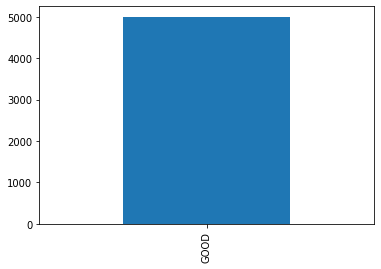

In [ ]:
pos_df = pd.read_pickle(path + '/5000_good_reviews_no_gap_02012023.pkl')

pos_df['label'].value_counts().plot.bar()

pos_df


,property_id,review_id,hotel_name,rating,label,review_text,review_token,content_bert_vector,content_wangchan_vector,content_xlmr_vector
0,583473,11379644,1 Bed Room @ Supalai Park Srinakarin,4.0,BAD,เป็นห้องส่วนตัว ไม่ใช่โรงแรม ไม่มีreception ร...,เป็น ห้องส่วนตัว ไม่ ใช่ โรงแรม ไม่ มี re...,"[0.20516930520534515, -0.2980044186115265, 0.5...","[0.9507721662521362, 0.49855199456214905, -0.2...","[0.0766182690858841, 0.07489442825317383, 0.02..."
1,583473,106302547,1 Bed Room @ Supalai Park Srinakarin,4.4,BAD,เพราะว่าพักในนี้จึงต้องการจองห้องที่นี่ให้ญาติ...,เพราะว่า พัก ใน นี้ จึง ต้องการ จอง ห้อง ที่นี...,"[0.037494637072086334, -0.3357238173484802, 0....","[1.046553611755371, -0.3122783899307251, -0.08...","[0.06421688199043274, 0.07423511892557144, 0.0..."
2,2325040,274154683,102 Ville,3.6,BAD,ห้องนอน แบบโจม สวยดี กลิ่นห้อง เปรี้ยว เตียง น...,ห้องนอน แบบ โจม สวย ดี กลิ่น ห้อง เปรี...,"[0.03935413062572479, -0.39039346575737, 0.417...","[1.4217027425765991, 0.5570076107978821, -0.15...","[0.08788846433162689, 0.07467065006494522, 0.0..."
3,2325040,209237954,102 Ville,4.8,BAD,1.น้ำที่ใช้น่าจะเป็นน้ำบาดาล (หรือน้ำคลอง) น้ำ...,1 น้ำ ที่ ใช้ น่าจะเป็น น้ำบาดาล หรือ น้ำ คล...,"[0.4179517328739166, -0.9775248765945435, 0.61...","[1.3006491661071777, 0.24572357535362244, -0.2...","[0.06931488960981369, 0.06735134869813919, -0...."
4,4943435,476665432,111 Mansion Roiet,2.4,BAD,กลิ่นอับแรงมากตั้งเเต่ เปิดห้องเข้าไปครั้งเเรก...,กลิ่นอับ แรง มาก ตั้ง เเต่ เปิด ห้อง เข้าไป ...,"[0.10289574414491653, -0.29940515756607056, 0....","[0.9201956987380981, -0.26277849078178406, 0.0...","[0.1012432873249054, 0.09472331404685974, 0.03..."
...,...,...,...,...,...,...,...,...,...,...
4995,2597389,223404395,white house,5.6,BAD,ห้องน้ำแคบมาก ฝักบัว กับชักโครกอยู่บริเวณเดียว...,ห้องน้ำ แคบ มาก ฝักบัว กับ ชักโครก อยู่ บร...,"[0.08581479638814926, -0.360297828912735, 0.48...","[1.5298511981964111, 0.6156182885169983, -0.16...","[0.08167234808206558, 0.09630654752254486, 0.0..."
4996,256900,251619748,White Inn Nongkhai,3.2,BAD,ห้องพัก ไม่สะอาด ผ้าปูที่นอนสกปรก เป็นคราบรอยเ...,ห้องพัก ไม่ สะอาด ผ้าปูที่นอน สกปรก เป็น...,"[-0.02733546495437622, -0.3714035451412201, 0....","[1.4650921821594238, 0.5808967351913452, -0.75...","[0.08098292350769043, 0.04306840896606445, 0.0..."
4997,85648,227301897,White Sand Beach Resort (SHA Extra Plus),2.0,BAD,ทางลงลาดชัน ยุงเยอะมาก ทะเลเคลื่อนแรง เล่นไม่ไ...,ทางลง ลาดชัน ยุง เยอะ มาก ทะเล เคลื่อน แรง...,"[0.1621532142162323, -0.25369971990585327, 0.2...","[1.631677508354187, 0.7296311855316162, -0.104...","[0.0856521800160408, 0.08290597051382065, 0.02..."
4998,85648,269915603,White Sand Beach Resort (SHA Extra Plus),2.0,BAD,ห้องติดภูเขา ห้องเก่ามากกกกกก ไม้ผุ เหม็นอับมา...,ห้อง ติด ภูเขา ห้อง เก่า มา กก กก กก ไม้ ผ...,"[0.28968897461891174, -0.5066888332366943, 0.4...","[1.2610809803009033, -0.14165706932544708, 0.2...","[0.05137608200311661, 0.06977402418851852, 0.0..."


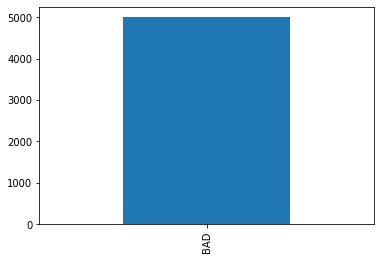

In [ ]:
neg_df = pd.read_pickle(path + '/5000_bad_reviews_no_gap_02012023.pkl')

neg_df['label'].value_counts().plot.bar()

neg_df

In [ ]:
combined_df = neg_df.append(pos_df, ignore_index=True)

# # # combined_df = pos_df.append(neg_df, ignore_index=True)

combined_df.rename(columns = {'review_token':'review_tokens'}, inplace = True)
combined_df

combined_df.to_pickle(path + "/10000_good_bad_reviews_no_gap_02012023.pkl")

In [ ]:
# SAMPLE GOOD TEXT WANGCHAN
text = all_df.iloc[5]['review_text']

print(text + '\n')

encoded_input = wangchan_tokenizer(text, return_tensors='pt').to(device)
encoded_input = adjust_encoded_input_wangchan(encoded_input)
encoded_input['input_ids'], encoded_input['input_ids'].size()

ข้อดีคืออยู่ไม่ไกลจากสถานฑูตหรือสถานที่ที่ต้องการไปทำธุระ  ข้อเสียคือ ความสะอาดยังไม่โอเคเท่าไหร่ ส่วนเรื่องของใช้ในห้องน้ำ ครีมอาบน้ำหรืออื่นๆหมดแล้วไม่คอยเติมให้หรือบางสิ่งหมดต้องทักต้องคอยถาม



(tensor([[    5,    10,  9878,    52,    55, 20868,  2262, 21684,    31,   947,
           2557, 24400,    10,  7471,    52,    10,  2287,   466,  1621,  1046,
            636,  1920,   103, 15468,    10,  2922,  4046,    31,   634,  3060,
             51,  1445,  2170,    21,    31, 14797,   408,    83,  3351, 13039,
            491,     6,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,   

In [ ]:
# SAMPLE BAD TEXT WANGCHAN
text = all_df.iloc[5002]['review_text']

print(text + '\n')

encoded_input = wangchan_tokenizer(text, return_tensors='pt').to(device)
encoded_input = adjust_encoded_input_wangchan(encoded_input)
encoded_input['input_ids'], encoded_input['input_ids'].size()

ที่พักค่อนข้างเป็นส่วนตัว เงียบ ไม่วุ่นวาย สามารถเดินด้วยเท้า 15 นาทีไปถนนวิทยุได้ ในซอยเดียวกันมีร้านสะดวกซื้อ 7-11 ในห้องปูด้วยพรม ตอนแรกกลัวว่าจะเหม็นอับ หรือจะหายใจไม่สะดวก แต่ไม่เหม็นอับเลย สามารถเดินด้วยเท้าไปสถานทูตเพื่อทำวีซ่าสหรัฐอเมริกาได้ โดนรวมถือว่าใช้ได้  ปล. สบู่ของทางที่พักหอมมาก ชอบมาก แต่อยากให้ติดพัดลมดูดอากาศในห้องน้ำเพิ่มเติม เพื่อไม่ให้กลิ่นจากการทำธุระส่วนตัวเข้ามาในห้อง



(tensor([[    5,    10,  3249,  1118,    17,   744,    10,  2278,   729,  2862,
             10,   151,   445,    45,  1548,    10,   338,    10,   705,    28,
            501,  3087,    15,    10, 11420,   276,    23,   298, 17020,    10,
          18183,    10,  3014,  1321,    45,  5883,  7211, 16185,  8147,  4968,
             10,  7172,  3306,  8464,    10,  1995,  8147,  4968,    48,    10,
            151,   445,    45,  1548,    28,  7207,  6668,  8044,  1136,   892,
             15, 14153,   315,  1140,  2923,    10,  1600,    11,    10,  8597,
             16,    75,  3249,  1741,    82,    10,  5612,   294,   929,   266,
          10852,  3297,  1038, 15468,   679,  2203,   868,  1899,   453, 23623,
            744,   240,  3014,     6,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,   

## PyThai NLP

### Pre-Processing

####Light Clean

In [ ]:
import string
import re
from pythainlp import word_tokenize
from pythainlp.corpus.common import thai_stopwords
from pythainlp import sent_tokenize, word_tokenize

thai_stopwords = list(thai_stopwords())

def text_process(text):

    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ"))
    final = final.translate(str.maketrans('','', string.punctuation))

    final = word_tokenize(final)
    final = " ".join(word for word in final)
    return final

all_df['review_tokens'] = all_df['review_text'].apply(text_process)
# all_df.head()

X = all_df[['review_tokens']]
y = all_df['label']

####Deep Clean

In [ ]:
import string
import re
from pythainlp import word_tokenize
from pythainlp.corpus.common import thai_stopwords
from pythainlp import sent_tokenize, word_tokenize
from thai2transformers import preprocess

thai_stopwords = list(thai_stopwords())

def text_process(text):

    t = preprocess.fix_html(text)
    t = preprocess.rm_brackets(t)
    t = preprocess.replace_newlines(t)
    t = preprocess.rm_useless_spaces(t)
    t = preprocess.replace_spaces(t)
    t = preprocess.replace_rep_after(t)

    tokens = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ"))
    tokens = tokens.translate(str.maketrans('','', string.punctuation))

    tokens = word_tokenize(tokens)
    tokens = preprocess.ungroup_emoji(tokens)
    tokens = preprocess.replace_wrep_post(tokens)

    final = " ".join(word for word in tokens)

    return final

all_df['deep_clean_review_tokens'] = all_df['review_text'].apply(text_process)
all_df.head()

deep_clean_X = all_df[['deep_clean_review_tokens']]
deep_clean_y = all_df['label']

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x:x.split(' '))

tfidf_vec = tfidf_vectorizer.fit_transform(X['review_tokens'])
tfidf_array = np.array(tfidf_vec.todense())

content_tfidf = []

for vec in tfidf_array:
  content_tfidf.append(vec)

all_df['content_tfidf_vector'] = content_tfidf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x:x.split(' '))

tfidf_vec = tfidf_vectorizer.fit_transform(deep_clean_X['deep_clean_review_tokens'])
tfidf_array = np.array(tfidf_vec.todense())

content_tfidf = []

for vec in tfidf_array:
  content_tfidf.append(vec)

all_df['content_deep_clean_tfidf_vector'] = content_tfidf

### Bag Of Word

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer=lambda x:x.split(' '))

bow_vec = count_vectorizer.fit_transform(X['review_tokens'])
bow_array = np.array(bow_vec.todense())

content_bow = []

for vec in bow_array:
  content_bow.append(vec)

all_df['content_bow_vector'] = content_bow


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer=lambda x:x.split(' '))

bow_vec = count_vectorizer.fit_transform(deep_clean_X['deep_clean_review_tokens'])
bow_array = np.array(bow_vec.todense())

content_bow = []

for vec in bow_array:
  content_bow.append(vec)

all_df['content_deep_clean_bow_vector'] = content_bow

In [ ]:
all_df.to_pickle(path + "/10000_good_bad_reviews_no_gap_02012023_completed.pkl")

# Word Cloud

## Good words

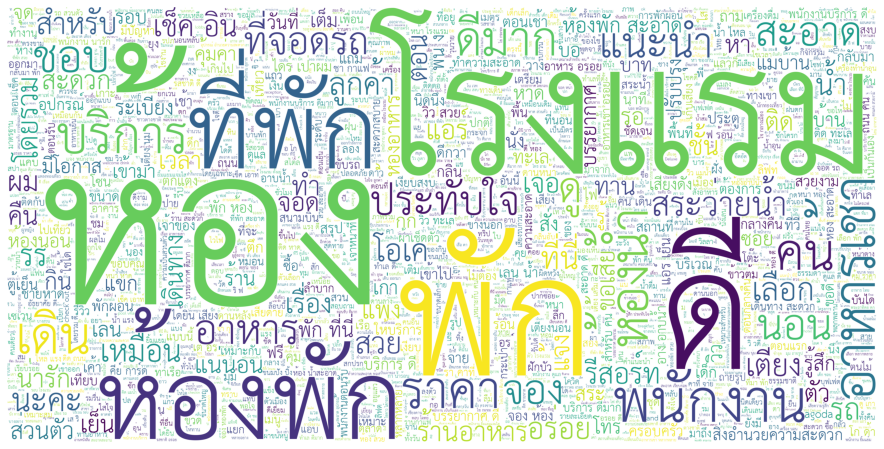

In [ ]:
import string
import re
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from pythainlp.corpus.common import thai_stopwords

thai_stopwords = list(thai_stopwords())


df_pos = all_df[all_df['label'] == 'GOOD']
pos_word_all = " ".join(text for text in df_pos['deep_clean_review_tokens'])
# print(pos_word_all)
reg = r"[ก-๙a-zA-Z']+"
fp =  path + '/THSarabunNew.ttf'
wordcloud = WordCloud(stopwords=thai_stopwords, background_color = 'white', max_words=2000, height = 2000, width=4000, font_path=fp, regexp=reg).generate(pos_word_all)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Bad words

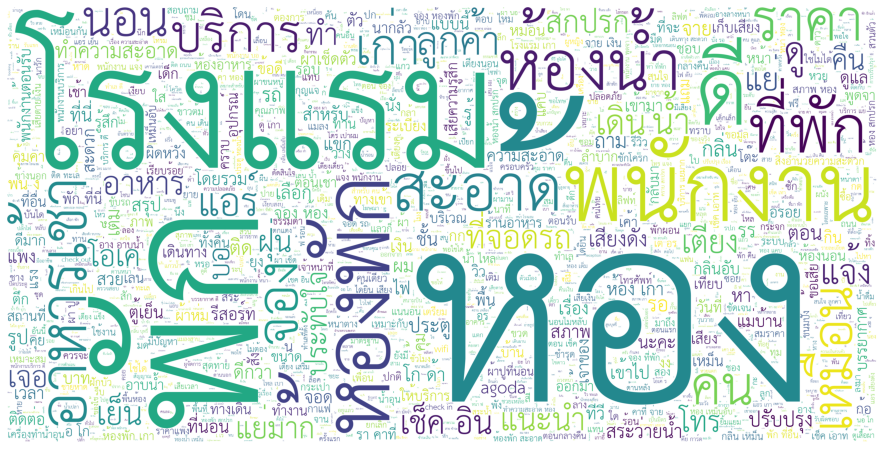

In [ ]:
import string
import re
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from pythainlp.corpus.common import thai_stopwords

thai_stopwords = list(thai_stopwords())


df_neg = all_df[all_df['label'] == 'BAD']
neg_word_all = " ".join(text for text in df_neg['deep_clean_review_tokens'])
# print(pos_word_all)
reg = r"[ก-๙a-zA-Z']+"
fp =  path + '/THSarabunNew.ttf'
wordcloud = WordCloud(stopwords=thai_stopwords, background_color = 'white', max_words=2000, height = 2000, width=4000, font_path=fp, regexp=reg).generate(neg_word_all)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Predictive Model Running

In [ ]:
all_df.head()

,property_id,review_id,hotel_name,rating,label,review_text,review_tokens,content_bert_vector,content_wangchan_vector,content_xlmr_vector,deep_clean_review_tokens,content_tfidf_vector,content_deep_clean_tfidf_vector,content_bow_vector,content_deep_clean_bow_vector
0,583473,11379644,1 Bed Room @ Supalai Park Srinakarin,4.0,BAD,เป็นห้องส่วนตัว ไม่ใช่โรงแรม ไม่มีreception ร...,เป็น ห้องส่วนตัว ไม่ ใช่ โรงแรม ไม่ มี re...,"[0.20516930520534515, -0.2980044186115265, 0.5...","[0.9507721662521362, 0.49855199456214905, -0.2...","[0.0766182690858841, 0.07489442825317383, 0.02...",เป็น ห้องส่วนตัว ไม่ ใช่ โรงแรม ไม่ มี re...,"[0.587876634388825, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.587876634388825, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,583473,106302547,1 Bed Room @ Supalai Park Srinakarin,4.4,BAD,เพราะว่าพักในนี้จึงต้องการจองห้องที่นี่ให้ญาติ...,เพราะว่า พัก ใน นี้ จึง ต้องการ จอง ห้อง ที่นี...,"[0.037494637072086334, -0.3357238173484802, 0....","[1.046553611755371, -0.3122783899307251, -0.08...","[0.06421688199043274, 0.07423511892557144, 0.0...",เพราะว่า พัก ใน นี้ จึง ต้องการ จอง ห้อง ที่นี...,"[0.4494652958255168, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4494652958255168, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2325040,274154683,102 Ville,3.6,BAD,ห้องนอน แบบโจม สวยดี กลิ่นห้อง เปรี้ยว เตียง น...,ห้องนอน แบบ โจม สวย ดี กลิ่น ห้อง เปรี...,"[0.03935413062572479, -0.39039346575737, 0.417...","[1.4217027425765991, 0.5570076107978821, -0.15...","[0.08788846433162689, 0.07467065006494522, 0.0...",ห้องนอน แบบ โจม สวย ดี กลิ่น ห้อง เปรี...,"[0.8021158649252179, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8021158649252179, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,2325040,209237954,102 Ville,4.8,BAD,1.น้ำที่ใช้น่าจะเป็นน้ำบาดาล (หรือน้ำคลอง) น้ำ...,1 น้ำ ที่ ใช้ น่าจะเป็น น้ำบาดาล หรือ น้ำ คล...,"[0.4179517328739166, -0.9775248765945435, 0.61...","[1.3006491661071777, 0.24572357535362244, -0.2...","[0.06931488960981369, 0.06735134869813919, -0....",1 น้ำ ที่ ใช้ น่าจะเป็น น้ำบาดาล หรือ น้ำ คล...,"[0.7871174707779647, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7871174707779647, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,4943435,476665432,111 Mansion Roiet,2.4,BAD,กลิ่นอับแรงมากตั้งเเต่ เปิดห้องเข้าไปครั้งเเรก...,กลิ่นอับ แรง มาก ตั้ง เเต่ เปิด ห้อง เข้าไป ...,"[0.10289574414491653, -0.29940515756607056, 0....","[0.9201956987380981, -0.26277849078178406, 0.0...","[0.1012432873249054, 0.09472331404685974, 0.03...",กลิ่นอับ แรง มาก ตั้ง เเต่ เปิด ห้อง เข้าไป ...,"[0.42346697184659093, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.42346697184659093, 0.0, 0.0, 0.0, 0.0, 0.0,...","[16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support , classification_report
import matplotlib.pyplot as plt

In [ ]:
ks_selected_df = all_df

# train test spilt 70/30 ratio
ks_df_train, ks_df_test, ks_df_y_train, ks_df_y_test = train_test_split(ks_selected_df, list(ks_selected_df['label']), test_size=0.3, random_state=0)

task = {
    "ks_df": {
        'data': ks_df_train,
        'col': 'content_bert_vector',
        'language_model' : 'BERT (multilingual)'
    },
    "kh_df": {
        'data': ks_df_train,
        'col': 'content_wangchan_vector',
        'language_model' : 'WangchanBERTa (monolingual)'
    },
    "xlmr_df": {
        'data': ks_df_train,
        'col': 'content_xlmr_vector',
        'language_model' : 'XML-RoBERTa (multilingual)'
    },
    "tfidf": {
        'data': ks_df_train,
        'col': 'content_tfidf_vector',
        'language_model' : 'TF-IDF'
    },
    "bow": {
        'data': ks_df_train,
        'col': 'content_bow_vector',
        'language_model' : 'Bag Of Word'
    },
    "deep_clean_tfidf": {
        'data': ks_df_train,
        'col': 'content_deep_clean_tfidf_vector',
        'language_model' : 'TF-IDF (Deep clean)'
    },
    "bow": {
        'data': ks_df_train,
        'col': 'content_deep_clean_bow_vector',
        'language_model' : 'Bag Of Word (Deep clean)'
    }
    
}

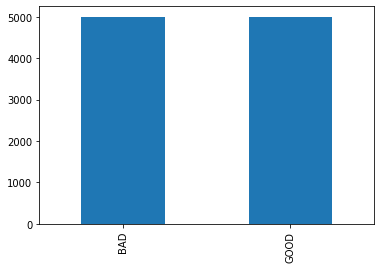

In [ ]:
ks_selected_df['label'].value_counts().plot.bar()

In [ ]:
is_manual = True

# loop data df
for i in task:

  col = task[i]['col']
  X = list(task[i]['data'][col])
  y = list(task[i]['data']['label'])

  X_test = list(ks_df_test[col])
  y_test = list(ks_df_test['label'])

  max_num_iter = 1000

  if is_manual:

    logreg_model = LogisticRegression(max_iter=max_num_iter, random_state=0,multi_class='multinomial')
    logreg_model.fit(X, y)
    y_pred = logreg_model.predict(X_test)
    print(task[i]['language_model'])
    print(classification_report(y_pred, y_test, digits = 4))

    print('\n')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BERT (multilingual)
              precision    recall  f1-score   support

         BAD     0.8723    0.8822    0.8772      1494
        GOOD     0.8818    0.8718    0.8768      1506

    accuracy                         0.8770      3000
   macro avg     0.8770    0.8770    0.8770      3000
weighted avg     0.8771    0.8770    0.8770      3000



WangchanBERTa (monolingual)
              precision    recall  f1-score   support

         BAD     0.9087    0.9129    0.9108      1504
        GOOD     0.9120    0.9078    0.9099      1496

    accuracy                         0.9103      3000
   macro avg     0.9103    0.9103    0.9103      3000
weighted avg     0.9103    0.9103    0.9103      3000



XML-RoBERTa (multilingual)
              precision    recall  f1-score   support

         BAD     0.9325    0.9227    0.9276      1527
        GOOD     0.9208    0.9308    0.9257      1473

    accuracy                         0.9267      3000
   macro avg     0.9266    0.9267    0.9267      

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bag Of Word (Deep clean)
              precision    recall  f1-score   support

         BAD     0.8835    0.8663    0.8748      1541
        GOOD     0.8617    0.8794    0.8704      1459

    accuracy                         0.8727      3000
   macro avg     0.8726    0.8728    0.8726      3000
weighted avg     0.8729    0.8727    0.8727      3000



TF-IDF (Deep clean)
              precision    recall  f1-score   support

         BAD     0.8795    0.8732    0.8764      1522
        GOOD     0.8704    0.8769    0.8736      1478

    accuracy                         0.8750      3000
   macro avg     0.8750    0.8750    0.8750      3000
weighted avg     0.8750    0.8750    0.8750      3000



